# Using A* algorithm and TSP to determine shortest tour around waypoints in a grid

Name:Yogesh Venkatesa Perumal

Roll:106118110

## Table of Contents
* [Defining The Grid](#Define-the-grid,-waypoints-and-obstacles)
* [Computing Distance Matrix](#Computing-the-distance-matrix)
* [Travelling Salesman Solver](#Travelling-Salesman-Solver)
* [Result](#Result)

In [1]:
from queue import PriorityQueue
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from icecream import ic
import numpy as np
import heapq

## Define the grid, waypoints and obstacles

Each point in a grid can be space(white), a waypoint(black) or an obstacle(grey).

In [2]:
def define_grid(length=20):
    area=length*length
    indices = np.random.choice(np.arange(area), size=area//10, replace=False)
    grid = np.zeros((length, length))
    
    
    obstacles_indices,waypoints_indices= indices[:-4],indices[-4:]
    grid.flat[obstacles_indices] = 1
    grid.flat[waypoints_indices] = 2
    

    y, x = divmod(waypoints_indices, length)
    waypoints=[]
    for i,j in zip(x,y):
        waypoints.append((i,j))
    
    y, x = divmod(obstacles_indices, length)
    obstacles=[]
    for i,j in zip(x,y):
        obstacles.append((i,j))
    
    
    return grid, waypoints,obstacles


def reset_the_grid_plot(grid,waypoints=None):
    
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap='Greys', interpolation='nearest',origin='upper')
 
    if waypoints!=None:
        for x,y in waypoints:
            plt.text(x=x,y=y,s=f"{(x,y)}",fontdict={"color":"red"},
                     bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', boxstyle='round,pad=0.2'))
            
def show_the_grid_plot():
    plt.title("Grid with Randomised Waypoints(black) and Obstacles(grey)")
    plt.show()


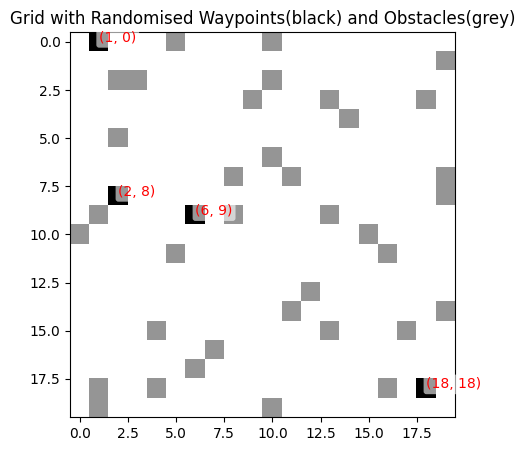

In [3]:
# Generate grid
grid,waypoints,obstacles=define_grid()
reset_the_grid_plot(grid=grid,waypoints=waypoints)
show_the_grid_plot()

In [4]:
print ("Waypoints are:")
print(waypoints)
print("Obstacles are:")
print(obstacles)

Waypoints are:
[(2, 8), (6, 9), (1, 0), (18, 18)]
Obstacles are:
[(13, 3), (10, 0), (8, 7), (11, 14), (10, 6), (2, 5), (12, 13), (10, 2), (14, 4), (1, 19), (16, 11), (0, 10), (5, 0), (19, 7), (2, 2), (5, 11), (4, 15), (15, 10), (8, 9), (4, 18), (19, 8), (1, 18), (3, 2), (10, 19), (18, 3), (17, 15), (1, 9), (6, 17), (16, 18), (9, 3), (13, 15), (13, 9), (19, 1), (11, 7), (19, 14), (7, 16)]


## Computing the distance matrix

### Using A* algorithm to Compute Shortest Path bw 2 Nodes

In [5]:
class Node():
    def __init__(self,parent=None, position=None):
        self.name=f"{position}"
        self.parent=parent
        self.position=position # (x,y)
        self.g=0
        self.h=0
        self.f=0

    #def __eq__(self,other):
    #    return self.position==other.position

    def __lt__(self, other):
        return self.f< other.f

def a_star(*,start, goal, grid):
    
    #ic(f"using a* to figure shortest distance bw {start} and {goal}")
    start_node = Node(parent=None, position=tuple(start))
    goal_node = Node(parent=None, position=tuple(goal))
    open_list = []
    closed_list = []
    heapq.heappush(open_list, (start_node.f, start_node))

    while open_list:
        current_node = heapq.heappop(open_list)[1] # from the open_list, obtaining the next highest priority (sorted by fscore) 
        #ic(f"next opennode is {current_node.name}")
        if current_node.position == goal_node.position: # implicitly comparing x and y coordinates of both nodes
            return current_node

        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
            new_node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            #node meeting one of these criteria will fail to be a potential future node to search
            if new_node_position[0] > (len(grid) - 1):
                #ic(f"node {node_position} border at bottom")
                continue
            elif new_node_position[0] < 0:
                #ic(f"node {node_position} border at top")
                continue
            elif new_node_position[1] > (len(grid[0]) - 1):
                #ic(f"node {node_position} border at right")
                continue
            elif new_node_position[1] < 0:
                #ic(f"node {node_position} border at left")
                continue
            
            if grid[new_node_position[1]][new_node_position[0]] == 1: # encountered obstacle
                #ic(f"encountered obstacle at {(new_node_position[0],new_node_position[1])}. fail.")
                continue
                
            # if here, the node has passed all the tests
            new_node = Node(parent=current_node, position=new_node_position)
            children.append(new_node)
        
        #print("camehere")
        #ic("iterated in all 4 directions")
        for child in children: # intent- final checks before adding child to open_list
            if child in closed_list:
                continue

            child.g = current_node.g + 1 # true distance travelled upto now
            child.h = abs(child.position[0] - goal_node.position[0]) + abs(child.position[1] - goal_node.position[1])
            child.f = child.g + child.h

            if any(child.position == open_node[1].position and child.g > open_node[1].g for open_node in open_list):
                continue
                
            # came here, this child node is perfectly eligible for future exploration
            heapq.heappush(open_list, (child.f, child)) 
            
        
        closed_list.append(current_node)
        #ic(f"closed_list is {closed_list}")
        
        
    return []


### Compute Distance matrix

In [6]:

def compute_distance_matrix(*,waypoints,grid):
    ap={}
    mapper_index_to_position={}
    
    n_rows,n_cols = len(waypoints),len(waypoints)
    distance_matrix = [[0 for j in range(n_cols)] for i in range(n_rows)]
    
    for i in range(len(waypoints)):
        for j in range(len(waypoints)):
            if i == j:
                continue
            
            start=waypoints[i] #start = (x,y)
            goal=waypoints[j] # end = (x,y)
            
            
            goal_node:Node= a_star(grid=grid,start=start,goal=goal)
            
            #Going Backwards to determine the path we took 
            pathway=[] #stores list of (x,y) coordinates on how to reach from start to end 
            t=goal_node
            while t.parent!=None:
                pathway.insert(0,t.position)
                t=t.parent
            pathway.insert(0,t.position)
            print(f"Pathway from {start} to {goal} is\n{pathway}\n")
            
            
            distance_matrix[i][j]=len(pathway)-1
            mapper_index_to_position[(i,j)]=(start,goal)
            ap[(start),(goal)]=[pathway,len(pathway)-1]
                
    return distance_matrix,mapper_index_to_position,ap


In [7]:
distance_matrix,mapper_index_to_position,ap=compute_distance_matrix(waypoints=waypoints,grid=grid)
# distance_matrix is storing the shortest paths
# mapper_index_to_position is used to get back (x,y) coordinates using index i (needed after tsp_solve)
# ap is a dict that returns [pathway,distance] on supplying (start,goal)

Pathway from (2, 8) to (6, 9) is
[(2, 8), (3, 8), (3, 9), (4, 9), (5, 9), (6, 9)]

Pathway from (2, 8) to (1, 0) is
[(2, 8), (2, 7), (1, 7), (1, 6), (1, 5), (1, 4), (1, 3), (1, 2), (1, 1), (1, 0)]

Pathway from (2, 8) to (18, 18) is
[(2, 8), (2, 9), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (7, 11), (7, 12), (8, 12), (9, 12), (9, 13), (9, 14), (9, 15), (10, 15), (11, 15), (11, 16), (12, 16), (12, 17), (13, 17), (14, 17), (15, 17), (16, 17), (17, 17), (17, 18), (18, 18)]

Pathway from (6, 9) to (2, 8) is
[(6, 9), (6, 8), (5, 8), (4, 8), (3, 8), (2, 8)]

Pathway from (6, 9) to (1, 0) is
[(6, 9), (5, 9), (5, 8), (4, 8), (4, 7), (4, 6), (4, 5), (4, 4), (4, 3), (4, 2), (4, 1), (3, 1), (3, 0), (2, 0), (1, 0)]

Pathway from (6, 9) to (18, 18) is
[(6, 9), (6, 10), (7, 10), (7, 11), (7, 12), (7, 13), (8, 13), (8, 14), (9, 14), (9, 15), (9, 16), (10, 16), (10, 17), (11, 17), (12, 17), (13, 17), (14, 17), (15, 17), (16, 17), (17, 17), (17, 18), (18, 18)]

Pathway from (1, 0) to (2, 8)

In [8]:
pd.DataFrame(distance_matrix)

,0,1,2,3
0,0,5,9,26
1,5,0,14,21
2,9,14,0,35
3,26,21,35,0


### Plots for all computed shortest points

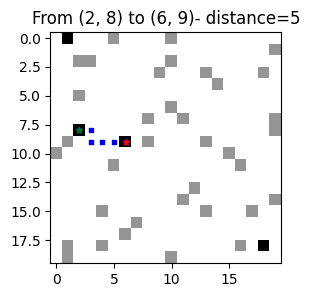

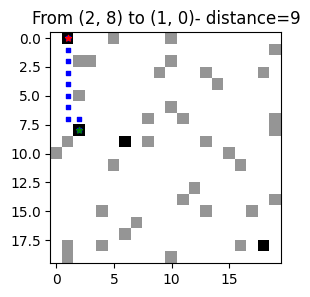

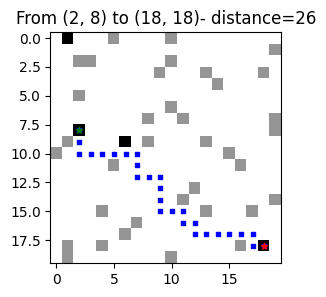

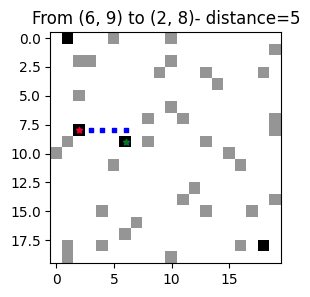

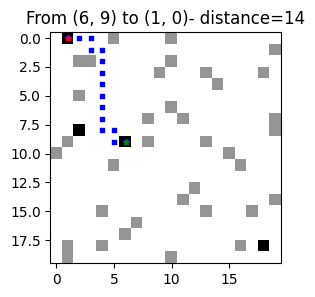

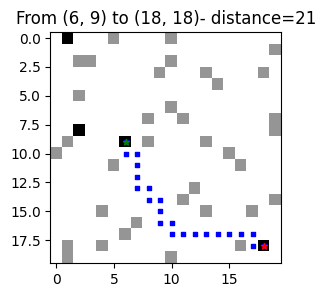

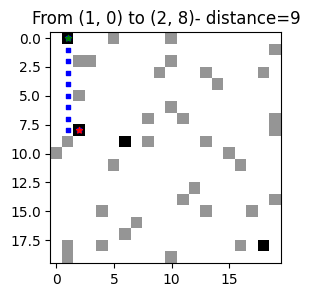

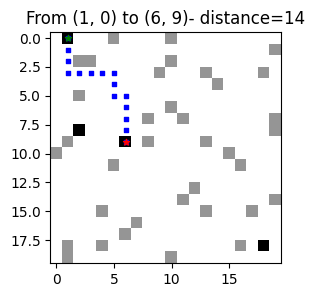

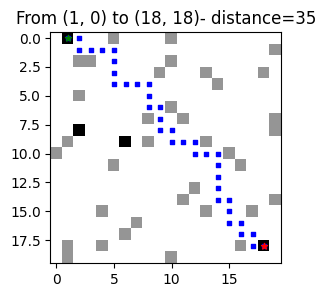

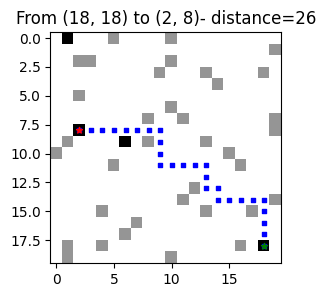

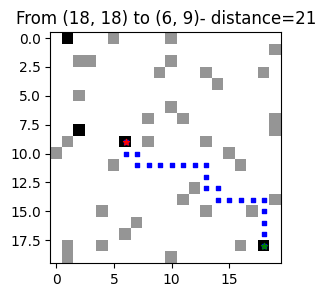

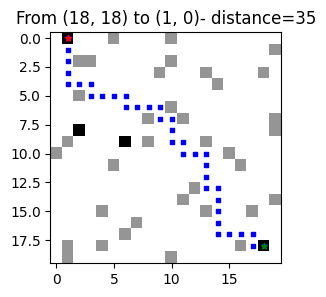

In [9]:
for (start,goal),[pathway,distance] in ap.items():
    
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(grid, cmap='Greys', origin='upper')

    # Mark the path
    for step in pathway:
        ax.scatter(step[0], step[1], marker='s', color='blue', s=10)

    # Mark the start and goal positions
    ax.scatter(start[0], start[1], marker='*', color='green', s=20)
    ax.scatter(goal[0], goal[1], marker='*', color='red', s=20)
    ax.set_title(f"From {start} to {goal}- distance={len(pathway)-1}")
    plt.show()


## Travelling Salesman Solver

In [10]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def solve_tsp(distance_matrix):
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        # Convert routing variable indices to distance matrix indices.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        # Retrieve the distance, handling infinity properly.
        distance = distance_matrix[from_node][to_node]
        if np.isinf(distance):
            return routing_model.registered_penalty()  # Large penalty for infeasible paths
        return int(distance)  # Convert float to int if necessar
        
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.Solve()
    if solution:
        index = routing.Start(0)
        plan_output = [] #'Route:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output.append(manager.IndexToNode(index)) #+= f' {manager.IndexToNode(index)} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        plan_output.append(manager.IndexToNode(index)) #+= f'{manager.IndexToNode(index)}\n'
    return plan_output,route_distance

In [11]:
print("For the previously computed distance matrix")
display(pd.DataFrame(distance_matrix))
plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix)

print("Result of TSP Solver is\n")
print(plan_output)

plan_output_mapped=[] 
for i in range(len(plan_output)-1):
    index_now=plan_output[i]
    index_next=plan_output[i+1]
    
    plan_output_mapped.append(mapper_index_to_position[index_now,index_next])
print(f"Therefore proposed route is {plan_output_mapped}")


print(f'Total Route distance: {route_distance}')


For the previously computed distance matrix


,0,1,2,3
0,0,5,9,26
1,5,0,14,21
2,9,14,0,35
3,26,21,35,0


Result of TSP Solver is

[0, 1, 3, 2, 0]
Therefore proposed route is [((2, 8), (6, 9)), ((6, 9), (18, 18)), ((18, 18), (1, 0)), ((1, 0), (2, 8))]
Total Route distance: 70


## Result 

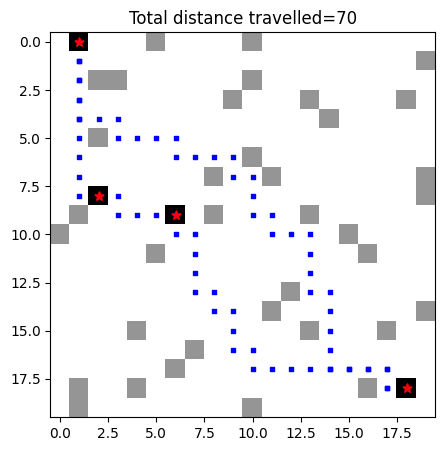

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(grid, cmap='Greys', origin='upper')

for i in range(len(plan_output)-1):
    index_now=plan_output[i]
    index_next=plan_output[i+1]
    
    start,goal=mapper_index_to_position[(index_now,index_next)]
    pathway,distance=ap[(start,goal)]

    # Mark the path
    for (step_x,step_y) in pathway:
        ax.scatter(step_x, step_y, marker='s', color='blue', s=10)

    #marking the start and goal positions
    ax.scatter(start[0], start[1], marker='*', color='red', s=40)
    ax.scatter(goal[0], goal[1], marker='*', color='red', s=40)
ax.set_title(f"Total distance travelled={route_distance}")
plt.show()